In [2]:
# Import resources
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
import sys

# Access project directory 
base_dir = "Your own Base dir"
sys.path.append(base_dir)

# Paths
dataset_dir = base_dir
model_dir = os.path.join(base_dir, 'model')

In [4]:
from Dataset import get_dataset_dict
 
# Load datasets
dataset_dict = get_dataset_dict(dataset_dir)

In [5]:
from Datapipeline import Augmentation, Dataset
 
## PARAMETERS
AUGMENTATION = Augmentation.HIGH
CROSS_ENTROPY = True
DATASET = Dataset.FERPLUS
N_CLASSES = 8
ORIGINAL_PREPROCESSING = True

# Model file name
MODEL_NAME = 'ferplus_model_pd'

In [6]:
## HYPERPARAMETERS
BATCH_SIZE = 128
EPOCHS = 1000
DROPOUT_RATE = 0.10
LEARNING_RATE = 0.005
LEAKY_RELU_SLOPE = 0.02
LR_PATIENCE = 20
PATIENCE = 30
REGULARIZATION_RATE = 0.01

In [7]:
from data import get_data_pipeline  # Use the new function
from Datapipeline import DataPipelineParams

# Data pipeline parameters
pipeline_params = DataPipelineParams(dataset=DATASET,
                                     cross_entropy=CROSS_ENTROPY,
                                     original_preprocessing=ORIGINAL_PREPROCESSING,
                                     batch_size=BATCH_SIZE,
                                     augmentation=AUGMENTATION)

pipeline_params_test = DataPipelineParams(dataset=DATASET,
                                          original_preprocessing=ORIGINAL_PREPROCESSING,
                                          batch_size=BATCH_SIZE,
                                          augmentation=AUGMENTATION)

# Data pipelines
# Data pipelines
training_pipeline = get_data_pipeline(dataset_df=dataset_dict['train'],
                                      params=pipeline_params,
                                      shuffle=True)  # Shuffle for training
validation_pipeline = get_data_pipeline(dataset_df=dataset_dict['valid'],
                                        params=pipeline_params_test)
test_pipeline = get_data_pipeline(dataset_df=dataset_dict['test'],
                                  params=pipeline_params_test)


Number of elements: 27956
Number of elements: 3199
Number of elements: 3153


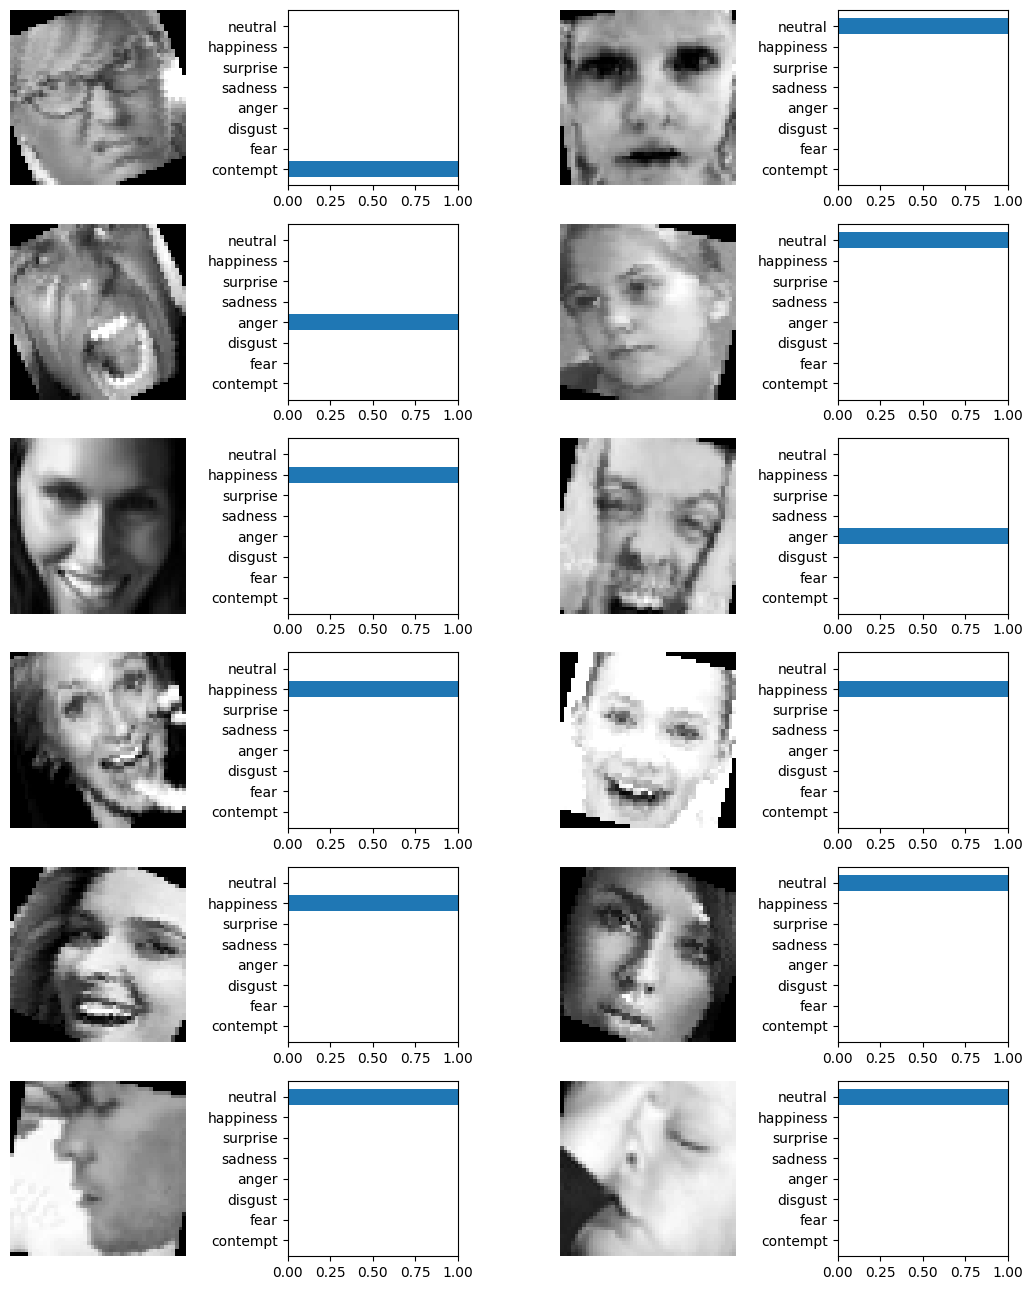

In [8]:
from data import get_fer_class_mapping, get_fer_plus_class_mapping
import predictions as ps

# Display sample imagesf
# Convert the DataLoader to an iterator and get the next batch
iterator = iter(test_pipeline)
image_batch, label_batch = next(iterator)

if DATASET == Dataset.FER:
    class_mapping = get_fer_class_mapping()
else:
    class_mapping = get_fer_plus_class_mapping()

if CROSS_ENTROPY:
    ps.display_cross_entropy_predictions(image_batch, 
                                         label_batch, 
                                        class_mapping)
else:
    ps.display_majority_predictions(image_batch, 
                                    label_batch, 
                                    class_mapping)

In [9]:
pip install torchsummary


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import models
from Datapipeline import Augmentation, Dataset
import torch
from torchinfo import summary

# Create an instance of the model
model = models.get_performance_model(leaky_relu_slope=LEAKY_RELU_SLOPE,
                                     dropout_rate=DROPOUT_RATE,
                                     regularization_rate=REGULARIZATION_RATE,
                                     n_classes=N_CLASSES,
                                     logits=True)

# Check model summary using torchinfo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print model summary
summary(model, input_size=(1, 1, 48, 48), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
PerformanceModel                         [1, 8]                    --
├─Conv2d: 1-1                            [1, 32, 48, 48]           320
├─BatchNorm2d: 1-2                       [1, 32, 48, 48]           64
├─Conv2d: 1-3                            [1, 32, 48, 48]           9,248
├─BatchNorm2d: 1-4                       [1, 32, 48, 48]           64
├─MaxPool2d: 1-5                         [1, 32, 24, 24]           --
├─Dropout2d: 1-6                         [1, 32, 24, 24]           --
├─Conv2d: 1-7                            [1, 64, 24, 24]           18,496
├─BatchNorm2d: 1-8                       [1, 64, 24, 24]           128
├─Conv2d: 1-9                            [1, 64, 24, 24]           36,928
├─BatchNorm2d: 1-10                      [1, 64, 24, 24]           128
├─MaxPool2d: 1-11                        [1, 64, 12, 12]           --
├─Dropout2d: 1-12                        [1, 64, 12, 12]           --
├

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Loss function
loss = nn.CrossEntropyLoss()  # Equivalent to CategoricalCrossentropy(from_logits=True)

# Optimizer (assuming you have a model instance called `model`)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [13]:
import torch
import os

# Early stopping parameters
best_val_loss = float('inf')
patience = PATIENCE  # Number of epochs to wait before stopping
counter = 0

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=LR_PATIENCE, min_lr=0.001)


# Model checkpoint paths
model_file_path_acc = os.path.join(model_dir, MODEL_NAME + '_acc.pth')
model_file_path_loss = os.path.join(model_dir, MODEL_NAME + '_loss.pth')


In [14]:
criterion = nn.CrossEntropyLoss()  # Define this before training


In [15]:
best_val_acc = 0.0  # Initialize best validation accuracy

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in training_pipeline:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)  # Use criterion instead of loss_function
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validation_pipeline:
            outputs = model(images)
            loss = criterion(outputs, labels)  # Fixed this
            val_loss += loss.item()

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)  # Get predicted class indices
            labels = labels.argmax(1)  # Convert one-hot encoded labels to class indices

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_loss /= len(validation_pipeline)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), model_file_path_loss)  # Save best loss model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

    # Save best accuracy model
    if val_accuracy > best_val_acc:  
        best_val_acc = val_accuracy  # Update best validation accuracy
        torch.save(model.state_dict(), model_file_path_acc)  # Save best accuracy model

    # Reduce learning rate if needed
    scheduler.step(val_loss)


KeyboardInterrupt: 

In [ ]:
import torch

# Load model
model_file_path_acc = "Your Model path"
model.load_state_dict(torch.load(model_file_path_acc, map_location=device))  # Ensure correct device
model.to(device)
model.eval()

PerformanceModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(

In [26]:
# Initialize test metrics
test_loss = 0.0
correct = 0
total = 0

In [27]:
# Check if dataloader is empty
if len(test_pipeline) == 0:
    print("⚠️ Warning: test_pipeline is empty! Check your dataloader.")
else:
    print("✅ Test dataloader loaded. Running evaluation...")


✅ Test dataloader loaded. Running evaluation...


In [28]:
# Evaluation loop
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_pipeline):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        # Debugging prints
        print(f"[Batch {batch_idx}] Outputs: {outputs.shape}, Labels: {labels.shape}")

        # Convert labels if needed
        if labels.dim() > 1:  
            labels = labels.argmax(1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total if total > 0 else 0  # Avoid division by zero
test_loss /= len(test_pipeline) if len(test_pipeline) > 0 else 1

print(f"📊 Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

[Batch 0] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 1] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 2] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 3] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 4] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 5] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 6] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 7] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 8] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 9] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 10] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 11] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 12] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 13] Outputs: torch.Size([128, 8]), Labels: torch.Size([128, 8])
[Batch 14] Outpu

In [17]:
import torch


test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_pipeline:  # Use actual test dataloader
        images, labels = images.to(device), labels.to(device)  # Move to GPU/CPU
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        # Check if labels need conversion
        if labels.dim() > 1:  # If labels are one-hot encoded
            labels = labels.argmax(1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
test_loss /= len(test_pipeline)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4885, Test Accuracy: 0.8382


In [18]:
model_file_path_acc = "model/ferplus_model_pd_acc.pth"  # Update path
model.load_state_dict(torch.load(model_file_path_acc))
model.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_pipeline:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if necessary

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        if labels.dim() > 1:  # Convert one-hot labels if necessary
            labels = labels.argmax(1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
test_loss /= len(test_pipeline)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.4742, Test Accuracy: 0.8497


In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to('cpu'), labels.to('cpu')

            outputs = model(inputs)
            
            print(f"Outputs shape: {outputs.shape}")  # Debugging
            print(f"Labels shape: {labels.shape}")  # Debugging
            
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predicted = torch.argmax(outputs, dim=1)  # FIXED
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    print(f"Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")  # <-- Add this
    return avg_loss, accuracy


In [ ]:
import torch

model_path = "Your own Model Path"
model_data = torch.load(model_path, map_location=torch.device("cpu"))

print(model_data.keys())  # Check the contents


odict_keys(['conv1.weight', 'conv1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight', 'conv2.bias', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'conv3.weight', 'conv3.bias', 'bn3.weight', 'bn3.bias', 'bn3.running_mean', 'bn3.running_var', 'bn3.num_batches_tracked', 'conv4.weight', 'conv4.bias', 'bn4.weight', 'bn4.bias', 'bn4.running_mean', 'bn4.running_var', 'bn4.num_batches_tracked', 'conv5.weight', 'conv5.bias', 'bn5.weight', 'bn5.bias', 'bn5.running_mean', 'bn5.running_var', 'bn5.num_batches_tracked', 'conv6.weight', 'conv6.bias', 'bn6.weight', 'bn6.bias', 'bn6.running_mean', 'bn6.running_var', 'bn6.num_batches_tracked', 'conv7.weight', 'conv7.bias', 'bn7.weight', 'bn7.bias', 'bn7.running_mean', 'bn7.running_var', 'bn7.num_batches_tracked', 'conv8.weight', 'conv8.bias', 'bn8.weight', 'bn8.bias', 'bn8.running_mean', 'bn8.running_var', 'bn8.num_batches_tracked', 'fc.weight',

In [30]:
emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

Predicted Emotion: Neutral - Probabilities: [9.6223658e-01 5.8352076e-03 9.1676563e-03 1.1430754e-02 2.3776967e-05
 8.1072834e-08 2.1152422e-04 1.1094472e-02]


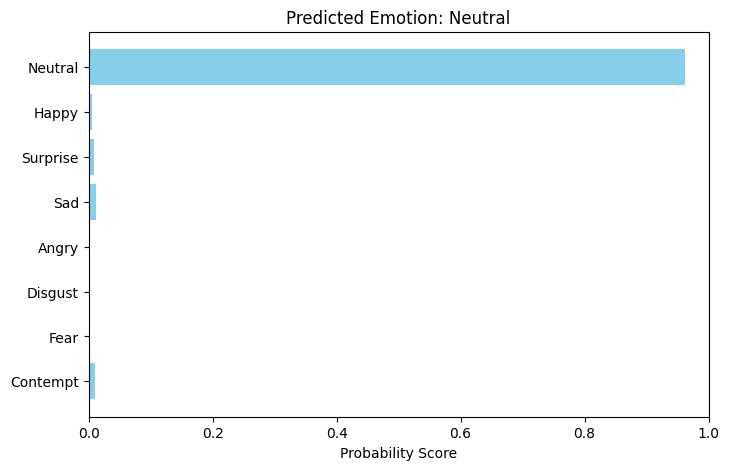

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from models import PerformanceModel

# ✅ Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PerformanceModel(input_shape=(1, 48, 48), n_classes=8, logits=True).to(device)
model.load_state_dict(torch.load(r"Your model Path", map_location=device))
model.eval()

# ✅ Corrected Emotion Order (FERPlus Order)
emotions = ["Neutral", "Happy", "Surprise", "Sad", "Angry", "Disgust", "Fear", "Contempt"]

# ✅ Load an image manually (make sure this is a face image)
img_path = "fer0028681.png"  # Change this to an actual image path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
img = cv2.resize(img, (48, 48))  # Resize to 48x48

# ✅ Convert & preprocess
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

face_tensor = transform(img).unsqueeze(0).to(device)

# ✅ Run model
with torch.no_grad():
    output = model(face_tensor)
    probs = torch.softmax(output, dim=1)[0].cpu().numpy()  # Convert logits to probabilities
    predicted_idx = np.argmax(probs)

# ✅ Print the result
print(f"Predicted Emotion: {emotions[predicted_idx]} - Probabilities: {probs}")

# ✅ Visualization - Bar Chart for Emotion Scores
plt.figure(figsize=(8, 5))
plt.barh(emotions, probs, color='skyblue')
plt.xlabel("Probability Score")
plt.title(f"Predicted Emotion: {emotions[predicted_idx]}")
plt.xlim(0, 1)  # Probabilities are between 0 and 1
plt.gca().invert_yaxis()  # Highest probability at the top
plt.show()
